# Example: Dumb Daily Bollinger Bands Autotrade Agent
In this example, we will explore an auto trade strategy similar to [Bollinger Bands](https://www.bollingerbands.com/) that computes a decision boundary based upon a region around a moving average. The basis of this approach is mean-reversion: if the share price is below the lower boundary, we have a potential buy signal; if it is above the upper boundary, we have a sell signal.

* __What makes this a dumb bot__? In this implementation of the auto trader, we only use our [Bollinger Bands](https://www.bollingerbands.com/) type logic to identify potential `buy` or `sell` signals. No additional information is used to help make these decisions.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Constants and process the aggregate share price data
Before setting up the simulation, we load and process the out-of-sample daily aggregate share price data for members of the list of [SP500 firms](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) from `01-03-2024` to `12-04-24`. Then, we set some constant values that we'll use throughout the rest of the notebook. In particular, in the `prerequisites` code block, we will:
* First, we'll load the out-of-sample data and remove tickers that do not have the maximum number of trading days. We'll store the cleaned data in the `dataset::Dict{String, DataFrame}` variable.
* Next, we'll get a list of all the tickers in the `dataset,` sort them alphabetically, and store them in the `all_tickers_array` variable.
* Finally, we'll set some constants that we'll use later in the study.

In [5]:
original_dataset = MyOutOfSamepleMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Second, let's iterate through our data and collect only those tickers with `maximum_number_trading_days::Int64` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = let
    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end

Dict{String, DataFrame} with 481 entries:
  "TPR"  => 233×8 DataFrame…
  "EMR"  => 233×8 DataFrame…
  "CTAS" => 233×8 DataFrame…
  "HSIC" => 233×8 DataFrame…
  "KIM"  => 233×8 DataFrame…
  "PLD"  => 233×8 DataFrame…
  "IEX"  => 233×8 DataFrame…
  "BAC"  => 233×8 DataFrame…
  "CBOE" => 233×8 DataFrame…
  "EXR"  => 233×8 DataFrame…
  "NCLH" => 233×8 DataFrame…
  "CVS"  => 233×8 DataFrame…
  "DRI"  => 233×8 DataFrame…
  "DTE"  => 233×8 DataFrame…
  "ZION" => 233×8 DataFrame…
  "AVY"  => 233×8 DataFrame…
  "EW"   => 233×8 DataFrame…
  "EA"   => 233×8 DataFrame…
  "NWSA" => 233×8 DataFrame…
  "BBWI" => 233×8 DataFrame…
  "CAG"  => 233×8 DataFrame…
  "GPC"  => 233×8 DataFrame…
  "FCX"  => 233×8 DataFrame…
  "GILD" => 233×8 DataFrame…
  "UNP"  => 233×8 DataFrame…
  ⋮      => ⋮

* Lastly, let's get a list of firms in the cleaned-up `dataset::Dict{String, DataFrame},` sort the list alphabetically, and save it in the `list_of_all_tickers` array:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Constants
Before moving on, let's specify some constants we'll use later. Please take a look at the comments following the value to describe what it is, its permissible values, units, etc.

In [119]:
number_of_trading_periods = maximum_number_trading_days; # how many days of 2024 data do we have?
start_trading_index = 1; # What trading day index will we start at? (≥ 1)
length_of_autotrading_run = maximum_number_trading_days - 1; # number of trading days
start_index = 1;  # index to start viewing the data. This value needs to >= 1
stop_index = start_index + length_of_autotrading_run; # index where we stop viewing the data. This value needs to be <= to number_of_trading_periods
view_range = range(start_index, stop = stop_index, step = 1) |> collect; # view_range is the range we use to look at (simulate) the data
initial_budget = 1000.0; # initial budget of the agent
θ = 0.05; # if we do sell, how much do we sell (fraction of current shares to sell)
γ = 0.5; # what fraction of the original budget do we invest initially?
my_ticker_of_interest = "NVDA"; # select a ticker

## Task 1: Compute simple moving average trade signals
In this task, we'll compute the simple moving average of the share price of your ticker of interest and develop a decision boundary, which we'll use in the subsequent tasks to formulate a trading policy. We'll use an [incremental simple moving average](https://en.wikipedia.org/wiki/Moving_average) where the average price is updated with new data as the algorithm marches through time. 
Let the typical price in period $\tau$ be given by $S_{\tau}$ (units: `USD/share`) and the moving average of the `tp` at time $\tau$ be given by $\hat{S}_{\tau}$ (units: `USD/share`). 
$$
\begin{equation}
\hat{S}_{\tau} = \hat{S}_{\tau - 1} + \alpha(\tau)\cdot\left(S_{\tau} - \hat{S}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function`.  The `learning function` controls how much new information is included in the update between $(\tau-1)\rightarrow\tau$. For example, if $\alpha(\tau) = 0$, no new information is added to the updated average estimate. 
* __What value for $\alpha(\tau)$__? A simple moving average computed over a time window of length $\mathcal{L}\geq{1}$ has a `learning function` given by $\alpha(\tau) = \mathcal{L}^{-1}$. Thus, as the window length increases in size, i.e., $\mathcal{L}\rightarrow\infty$, the simple moving average learning rate goes to zero $\alpha(\tau) \rightarrow{0}$. We'll select a $\alpha(\tau)$ value to capture some desired time scale.

Let's specify a constant value for the `learning function` such that $0<\alpha(\tau)<1$, and save it in the `α::Float64` variable. 

In [121]:
α = (1/20); # students can update this!

Next, get the observed share price for the ticker specified in the `my_ticker_of_interest::String` variable from the `dataset::Dict{String, DataFrame}` dictionary. Save the data in the `typical_price_array::Array{Float64,1}` array variable:

In [123]:
typical_price_array = dataset[my_ticker_of_interest][!,:open]; # we can choose different prices here {open | close | high | low | vwap}

Next, using the incremental update expression above, let's compute the moving average. 
* First, we initialize some memory, and next, we initialize the average `mtypical_price_array` series with the `typicalprice` value, in this case, the actual `typicalprice` value. Thus, at the first time step (array index `1`), the `mtypical_price_array = typicalprice.` Then, we compute the moving average using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for).
* For each time step `2 ... number_of_trading_periods`, we use the incremental update expression to compute the average value and store it in the `mtypical_price_array::Array{Float64,1}` array.

In [125]:
mtypical_price_array = let
    
    mtypical_price_array = Array{Float64,1}(undef, number_of_trading_periods);
    mtypical_price_array[1] = typical_price_array[1]; 
    
    for i ∈ 2:number_of_trading_periods
        previous_mtp = mtypical_price_array[i-1];
        current_tp = typical_price_array[i];
        mtypical_price_array[i] = previous_mtp + α*(current_tp - previous_mtp);
    end
    mtypical_price_array;
end;

#### Visualize the MTP
`Unihide` the code block below to see how we plotted the actual and moving average for `daily` aggregates of `my_ticker_of_interest.`
* The `typicalprice` for `my_ticker_of_interest` is shown in the blue-line, while the moving average of the typical price (mtp) is shown by the red-line. The mtp is a smoothed and lagged version of the `typicalprice` with the high-frequency information removed. Thus, it gives a slower picture of the `typicalprice` dynamics. The $\alpha(\tau)$ parameter controls the inclusion of fast or slow dynamics.
* __What is the signifinance of $\alpha(\tau)$__? The parameter $\alpha(\tau)$ represents a time constant measured; when $\alpha(\tau)$ is large, the moving average typical price (mtp) trajectory includes high-frequency data. Conversely, when $\alpha(\tau)$ is small, only slow dynamics or low-frequency information is retained in the mtp. This means that data with a frequency of $\alpha(\tau)$ or below is included in the mtp, while data with a frequency greater than $\alpha(\tau)$ is excluded.

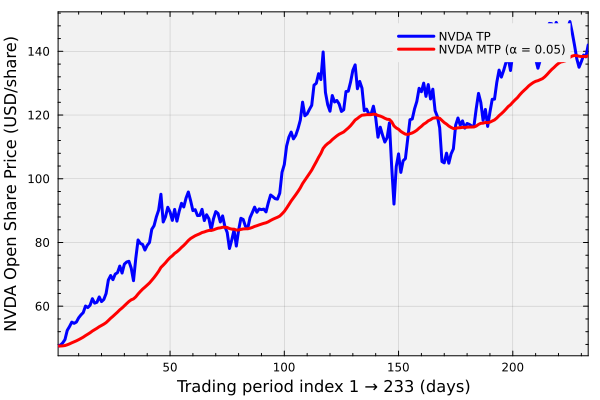

In [127]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, view_range, typical_price_array[view_range],c=:blue, xlims=(first(view_range), last(view_range)), lw=3, 
        label="$(my_ticker_of_interest) TP", xminorticks=5, yminorticks=5)
    plot!(view_range, mtypical_price_array[view_range], c=:red, lw=3, label="$(my_ticker_of_interest) MTP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index $(first(view_range)) → $(last(view_range)) (days)", fontsize=18)
    ylabel!("$(my_ticker_of_interest) Open Share Price (USD/share)", fontsize= 18);
end

### TODO: Develop a decision boundary
The moving average typical price (mtp) gives us a reference trajectory to use as a decision boundary, i.e., a `my_ticker_of_interest` price level that we'll use to make `{buy, hold, sell}` decisions. 
* `Hypothesis`: If `typicalprice` < `mtypicalprice,` we'll buy shares as we expect `my_ticker_of_interest` to be oversold, and the price will revert to the `mtypicalprice` value. On the other hand, if `typicalprice` > `mtypicalprice,`  we will sell shares. In this case, we expect that `my_ticker_of_interest` is overbought, and the price will drop to the `mtp` price.

However, let's refine this hypothesis further and add a buffer of size $\pm\,\beta\cdot\sigma$ around the `mtypicalprice` trajectory in which we hold, i.e., do not sell any shares. The multiplier $\beta$ is a user-adjustable hyperparameter, while $\sigma$ is the standard deviation of the `mtypicalprice,` that we calculate next. This is [a similar concept to Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands).

#### Calculate the decision boundary standard deviation
Like the incremental moving average for the share price shown above, suppose the average standard deviation at time step $\tau$ is given by $\hat{\sigma}_{\tau}$. We can incrementally update this value as new data becomes available. By analogy to the price expression, we propose an update rule for the standard deviation, which we'll use in our decision process, of the form:
$$
\begin{equation}
\hat{\sigma}_{\tau} = \hat{\sigma}_{\tau - 1} + \alpha(\tau)\cdot\left(\epsilon_{\tau} - \hat{\sigma}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function` from above, and $\epsilon_{\tau}$ is the 1-step standard deviation given by the expression:
$$
\begin{equation}
\epsilon_{\tau} = \sqrt{\left(S_{\tau} - \hat{S}_{\tau}\right)^2}
\end{equation}
$$
The $S_{\tau}$ value denotes the typical price at time $\tau$, while the $\hat{S}_{\tau}$ term denotes the moving average typical price (mtp) at time $\tau$. Thus, the $\epsilon_{\tau}$ term measures the residual between the `tp` and the `mtp` price. 
* To implement the moving average calculation, first, we allocate some space for the $\hat{\sigma}_{\tau}$ values in the `decision_boundary_array::Array{Float64,1}` array. We then initialize the first value of this series to zero, i.e., we have complete knowledge of the average price at index `1` because we know that `tp = mtp` at index `1,` thus $\hat{\sigma}_{1} = 0$. Then, we process each time step `2 ... number_of_trading_periods` using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where we implement the incremental update expression above and store the result in the `decision_boundary_array::Array{Float64,1}` array.

In [130]:
decision_boundary_array = let
    decision_boundary_array = Array{Float64,1}(undef, number_of_trading_periods);
    decision_boundary_array[1] = 1.0; # hmmmm. what does this do?
    for i ∈ 2:(number_of_trading_periods)
        previous_decision_boundary = decision_boundary_array[i-1];
        ϵ = (typical_price_array[i] - mtypical_price_array[i])^2 |> x -> sqrt(x);
        decision_boundary_array[i] = previous_decision_boundary + α*(ϵ - previous_decision_boundary);
    end
    decision_boundary_array
end;

#### Visualize the decision boundary
Let's plot the `decision_boundary_array,` i.e., the $\hat{\sigma}_{\tau}$ values and the `tp` and `mtp` trajectories, to see the decision boundaries. First, select a value for the multiplier hyperparameter $\beta$. 
* __What does $\beta$ do__? This user-adjustable parameter controls the width of the hold band. The $\beta$ parameter is akin to a [z-value in statistics](https://en.wikipedia.org/wiki/Standard_score); large values of $\beta$ will lead to a wide hold band, which means only extreme events will be classified as buy or sell signals. On the other hand, small $\beta$ values will allow more buy and sell moves. Let's set $\beta\geq{0}$.

In [132]:
β = 1.0;

`Unhide` the code block below to reveal the code for plotting the tp, the mtp, and the decision boundary trajectory for the $\beta\geq{0}$ case.
* The `tp` is shown by the blue line, the moving volume-weighted average price (mtp) is shown in the red line, and the $\pm\,\beta\cdot\hat{\sigma}_{\tau}$ region around the `mtp` is shown in the gray shaded area. We can now use the hold region, i.e., the gray region, as the boundary for our auto-trading agent.
* Values of `tp` inside the gray region indicate our agent is in the hold state. On the other hand, if the tp falls below the gray region, the agent will be in the buy state. Finally, for tp values above the gray region, the agent will be in the sell state.
* We can imagine that each agent has a unique risk tolerance represented by a different value of $\beta$, and also a different value for the `learning function` $\alpha(\tau)$. Consequently, each agent might make other decisions based on their parameter values.

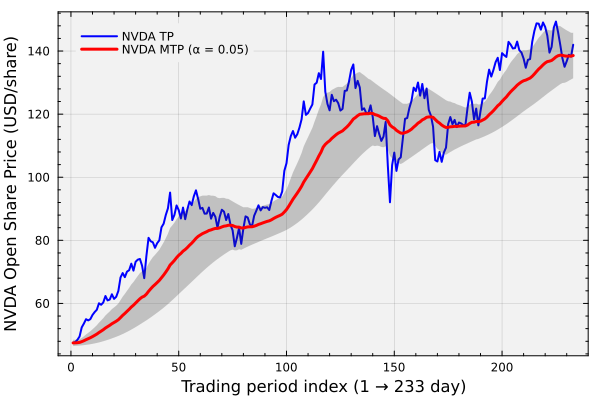

In [134]:
let    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot(q, view_range, typical_price_array[view_range],c=:blue, lw=2, label = "$(my_ticker_of_interest) TP")

    UB = mtypical_price_array[view_range] + β*decision_boundary_array[view_range];
    LB = mtypical_price_array[view_range] - β*decision_boundary_array[view_range];
    plot!(view_range, mtypical_price_array[view_range], fillrange = UB, label="", alpha=0.25, c=:gray20, xminorticks=5, yminorticks=5)
    plot!(view_range, mtypical_price_array[view_range], fillrange = LB, label="", alpha=0.25, c=:gray20)
    plot!(view_range, mtypical_price_array[view_range], c=:red, lw = 3, label="$(my_ticker_of_interest) MTP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) day)", fontsize=18)
    ylabel!("$(my_ticker_of_interest) Open Share Price (USD/share)", fontsize= 18);
end

## Task 2: How well does a mean-reversion trading strategy perform?
In this task, we'll explore the performance of a trader using the mean reversion strategy developed in Task 1. However, before we let the auto trader loose, let's formulate an alternative investment against which we can compare the trading bot. We want to compare apples to apples, so let's suppose our alternative investment was to buy and hold the `my_ticker_of_interest` on the first trading day.

In [136]:
alternative_investement_wealth_array = let

    # initialize -
    number_of_trading_periods = length(view_range);
    share_price_data_df = dataset[my_ticker_of_interest];
    
    # generate a *random* fill price
    j = view_range[1];
    open = share_price_data_df[j,:open]
    low = share_price_data_df[j,:low];
    high = share_price_data_df[j,:high];
    close = share_price_data_df[j,:close];
    θ = rand();
    fillprice = θ*high + (1-θ)*low;

    @show j, fillprice, open, high, low, close

    # how many shares do we buy?
    n = initial_budget/fillprice;

    wealth_array = Array{Float64,1}(undef, number_of_trading_periods);
    for i ∈ eachindex(view_range)
        j = view_range[i];
        close_price = share_price_data_df[j,:close];
        wealth_array[i] = n*close_price;
    end
    
    wealth_array;
end;

(j, fillprice, open, high, low, close) = (1, 47.63070176704909, 47.485, 48.1841, 47.32, 47.569)


In [137]:
alternative_investement_wealth_array

233-element Vector{Float64}:
  998.704579929331
 1007.7113756321979
 1030.7847287264892
 1097.04451249863
 1115.6669548959333
 1141.0707376476096
 1150.9803124069413
 1148.6288878877776
 1183.732296781003
 1176.8249872559604
 1198.9535715702307
 1249.0053220495665
 1252.4274845194204
    ⋮
 2942.4298782210208
 3086.4546300197803
 3062.9403848281463
 3079.3163770151773
 2980.2206294218613
 2855.7210990768695
 2874.6164746772893
 2841.444593067663
 2902.5396408423553
 2910.5176883180884
 2944.7393130166274
 3047.1942384944623

Next, Let's construct the array that holds the actions of the agent. The `encoded_decision_action_array::Array{Int64,1}` holds the action the trading agent (as `0`, `1`, or `2`) will take at each time step. Our trading agent chooses an action from $\mathcal{A} \equiv \left\{\text{buy},\text{hold},\text{sell}\right\}$, where `0 = buy`, `1 = hold` and `2 = sell`. 

In [139]:
encoded_decision_action_array = let

    # initialize -
    number_of_trading_periods = length(view_range);
    UB = mtypical_price_array[view_range] + β*decision_boundary_array[view_range]; # upper bound: above this: sell
    LB = mtypical_price_array[view_range] - β*decision_boundary_array[view_range]; # lower bound: below this buy    
    encoded_state_array = Array{Int64,1}(undef, number_of_trading_periods);
    
    for i ∈ eachindex(view_range)

        j = view_range[i];
        
        typical_price = typical_price_array[j]; # observed open
        if (typical_price ≤ LB[i])
            encoded_state_array[i] = 0; # buy
        elseif (typical_price ≥ UB[i])
            encoded_state_array[i] = 2; # sell
        else
            encoded_state_array[i] = 1; # hold
        end        
    end

    # return -
    encoded_state_array;
end;

Now that we have the action states, we can simulate the trader's performance with some typical values. This algorithm below makes a few implementation assumptions that are worth discussion:
* __Random fill price__: We assume that when an agent buys or sells shares, they purchase (or sell) the shares at a random price value between the `low` and `high` value observed in the period. In this implementation, orders _always get filled_.
* __Purchase and sell volumes__: The agent buys `buy_side_order_volume::Float64` number of shares when purchasing shares, and sells $\theta$ fraction of thier position when selling the shares. The agent can not sell shares they don't own.
* __Budget__: The agent has an investment budget of `B USD` that they can spend. The agent cannot borrow money.

`Unhide` the trading bot code below to see how we simulated the performance of our bot for `2024`.

In [141]:
ledger_random_fill = let

    # get share price data -
    share_price_data_df = dataset[my_ticker_of_interest];
    
    
    # initialize -
    number_of_trading_periods = length(view_range);
    j = view_range[1];
    H = share_price_data_df[j,:high];
    L = share_price_data_df[j,:low];
    f = rand();
    initial_fill_price = f*H + (1-f)*L;
    
    n = (γ*initial_budget)/initial_fill_price; # we initially have this many shares
    B = (1-γ)*initial_budget;
    B_prev = B;
    start_price = share_price_data_df[1,:open];
    buy_side_order_volume = (0.05*B)/(start_price) # If we do buy, how big is the order? (fraction of our Budget)

    
    ledger = DataFrame();
    cash_dictionary = Dict{Int64,Float64}();
    cash_dictionary[0] = B; # we start out with some number
    shares_dictionary = Dict{Int64,Float64}();
    shares_dictionary[0] = n;
    
    # at what price do we get filled?
    average_placement_price = 
    for i ∈ eachindex(view_range)
        
        j = view_range[i];
        open = share_price_data_df[j,:open];
        low = share_price_data_df[j,:low];
        high = share_price_data_df[j,:high];
        close = share_price_data_df[j,:close];

        f = rand();
        filled_price = f*high + (1-f)*low; # we are somewhere between the low and high price for the period
        
        action = encoded_decision_action_array[i]; # what action do we do?
        if (action == 0) # buy

            # do we have enough money to make this trade? Need to check by budget
            cost_of_proposed_trade = buy_side_order_volume*filled_price;
            if (cost_of_proposed_trade ≤ B)

                # update 
                cash_dictionary[i] = cash_dictionary[i-1] - buy_side_order_volume*filled_price; # update the cash dictionary
                shares_dictionary[i] = shares_dictionary[i-1]+buy_side_order_volume; # update the shares dictionary
                B += -1*cost_of_proposed_trade; # update the budget
    
            else

                # We don't have enough money to implement this trade, so we hold
                shares_dictionary[i] = shares_dictionary[i-1]; # no change
                cash_dictionary[i] = cash_dictionary[i-1]; # no change    
            end
            
        elseif (action == 2) # sell
            if (shares_dictionary[i-1] ≥ 0)

                n_sell = θ*shares_dictionary[i-1]; # sell θ fraction of my current position
                cost_of_proposed_trade = n_sell*filled_price;
                
                cash_dictionary[i] = cash_dictionary[i-1] + cost_of_proposed_trade # update the cash dictionary
                shares_dictionary[i] = (1-θ)*shares_dictionary[i-1]; # how many shares do we have left?  
                B += 1*cost_of_proposed_trade; # update the budget
            end
        else
            # println("Hold action: current $(value) USD")
            shares_dictionary[i] = shares_dictionary[i-1]; # no change
            cash_dictionary[i] = cash_dictionary[i-1]; # no change
        end

        # compute some stuff -
        Δn = shares_dictionary[i] - shares_dictionary[i-1];
        Δcash = cash_dictionary[i] - cash_dictionary[i-1];
        
        # capture data -
        row_df = (
            timeperiod = i,
            action = action,
            open = open,
            fillprice = filled_price,
            nₒ = shares_dictionary[i-1],
            n₁ = shares_dictionary[i],
            Δn = Δn,
            Bₒ = B_prev,
            B₁ = B,
            ΔB = Δcash,
    
            LV = (shares_dictionary[i])*close,
            wealth = B + (shares_dictionary[i])*close
        );

        push!(ledger, row_df);
        B_prev = B;
    end

   ledger;
end;

In [142]:
# filter(:action => a-> a == 2, ledger_random_fill)
ledger_random_fill[1:200,:]

Row,timeperiod,action,open,fillprice,nₒ,n₁,Δn,Bₒ,B₁,ΔB,LV,wealth
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,47.485,47.8073,10.507,10.507,0.0,500.0,500.0,0.0,499.807,999.807
2,2,1,47.767,47.8599,10.507,10.507,0.0,500.0,500.0,0.0,504.315,1004.31
3,3,1,48.462,49.3673,10.507,10.507,0.0,500.0,500.0,0.0,515.862,1015.86
4,4,2,49.512,50.6585,10.507,9.98165,-0.52535,500.0,526.613,26.6134,521.571,1048.18
5,5,2,52.401,52.3794,9.98165,9.48257,-0.499083,526.613,552.755,26.1416,503.904,1056.66
6,6,2,53.616,54.0871,9.48257,9.00844,-0.474128,552.755,578.399,25.6442,489.609,1068.01
7,7,2,54.999,55.327,9.00844,8.55802,-0.450422,578.399,603.32,24.9205,469.168,1072.49
8,8,2,54.62,54.6467,8.55802,8.13012,-0.427901,603.32,626.703,23.3834,444.799,1071.5
9,9,2,55.018,55.4593,8.13012,7.72361,-0.406506,626.703,649.248,22.5445,435.473,1084.72


### Visualize
Let's visualize the total value of the agent's portfolio and the budget available as a function of time.

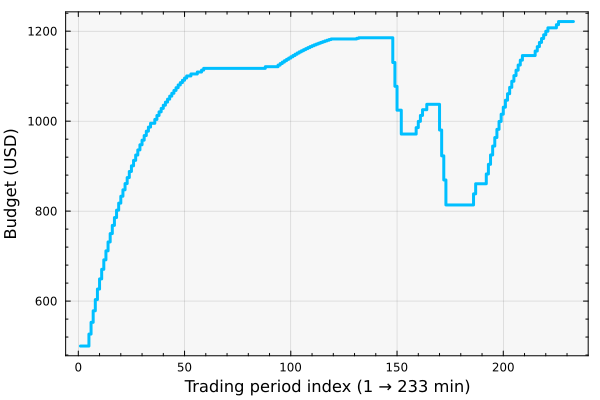

In [144]:
let
    plot(ledger_random_fill[:,:Bₒ], c=:deepskyblue1, lw=3, label="", linetype=:steppost, bg="gray97", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) min)", fontsize=18,  xminorticks=5, yminorticks=5)
    ylabel!("Budget (USD)", fontsize=18);
end

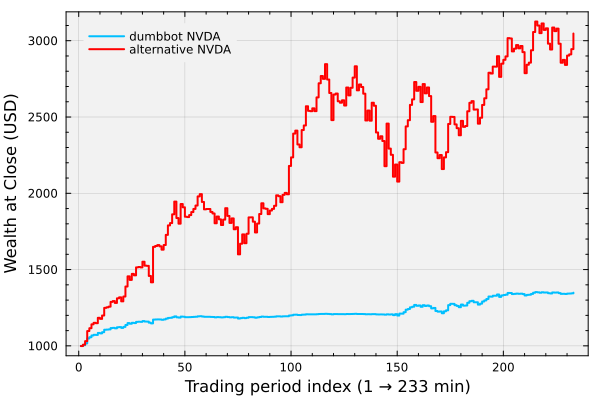

In [145]:
let
    plot(ledger_random_fill[:,:wealth], c=:deepskyblue1, lw=2, label="dumbbot $(my_ticker_of_interest)", linetype=:steppost, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    plot!(alternative_investement_wealth_array, lw=2, label="alternative $(my_ticker_of_interest)", linetype=:steppost, c=:red)
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) min)", fontsize=18,  xminorticks=5, yminorticks=5)
    ylabel!("Wealth at Close (USD)", fontsize=18);
end

#### Save the data
We'll want to compare our `dumb` bot to its `smart` bot sibling, so let's save the ledger and trade signals data to disk as a [HDF5 encoded binary file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). First, let's specify a path to save the file in the `path_to_saved_file::String` variable:

In [147]:
path_to_saved_file = joinpath(_PATH_TO_DATA, "Dumbbot-ticker-$(my_ticker_of_interest)-OOS-2024.jld2");

Then we write an [`HDF5 binary file`](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) holding our data to the location specified by `path_to_save_file.` We use the [save(...) function exported by the JLD2.jl package to write a binary save file](https://github.com/JuliaIO/JLD2.jl.git) (later we'll use to the `load(...)` function to reload this data):

In [149]:
save(path_to_saved_file, Dict("ledger"=> ledger_random_fill, 
        "actions" => encoded_decision_action_array, "β" => β, "initial_budget" => initial_budget,
        "θ" => θ, "γ" => γ, "α" => α));

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.